In [1]:
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import GridSearchCV


from urllib.request import urlretrieve
import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def data_download(url, filename):
    
    #os.chdir('datasets/')
    if not os.path.exists(filename):
        filename,_ = urlretrieve(url+filename,filename)
    else:
        if filename == 'text8.zip':
            statinfo = os.stat(filename)
            print("{} has already existed,file size are {}".format(filename, statinfo.st_size))
        elif filename == '20news-bydate.tar.gz':
            statinfo = os.stat(filename)
            print("{} has already existed,file size are {}".format(filename, statinfo.st_size))
        else:
            raise Exception("Please check your origin dataset.")
    return filename

In [3]:
news = data_download('http://www.qwone.com/~jason/20Newsgroups/', '20news-bydate.tar.gz')
text8 = data_download('http://mattmahoney.net/dc/', 'text8.zip')

20news-bydate.tar.gz has already existed,file size are 14464277
text8.zip has already existed,file size are 31344016


In [4]:
from sklearn.datasets import load_files
import codecs
import pickle
import sys
import tarfile

CACHE_NAME = "20news-bydate.pkz"
TRAIN_FOLDER = "20news-bydate-train"
TEST_FOLDER = "20news-bydate-test"

def load_categories(fpath):
    with tarfile.open(fpath) as tar:
        tar.extractall()
        tar.close()
        
    cache = dict(train=load_files(TRAIN_FOLDER, encoding='latin1'),
                 test=load_files(TEST_FOLDER, encoding='latin1'))
    compressed_content = codecs.encode(pickle.dumps(cache), 'zlib_codec')
    
    cache_path = CACHE_NAME
    with open(cache_path, 'wb') as f:
        f.write(compressed_content)
    #return cache
        
load_categories('20news-bydate.tar.gz')

In [5]:
from sklearn.utils import shuffle

def read_categories(subset,random_state=42):

     if os.path.getsize(CACHE_NAME):
        try:
            with open(CACHE_NAME, 'rb') as f:
                compressed_content = f.read()
            uncompressed_content = codecs.decode(
                compressed_content, 'zlib_codec')
            cache = pickle.loads(uncompressed_content)
        except Exception as e:
            print(80 * '_')
            print('Cache loading failed')
            print(80 * '_')
            print(e) 
        data = cache[subset]
        data.data, data.target = shuffle(data.data, data.target,random_state=random_state)
        
        return data

In [7]:
news_train = read_categories(subset='train')
news_test = read_categories(subset='test')
print(news_train.data[0])
print(news_train.target[:5])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





[ 7  4  4  1 14]


观察20类新闻的分布情况，每种新闻的总数分别是多少

{0: 480, 1: 584, 2: 591, 3: 590, 4: 578, 5: 593, 6: 585, 7: 594, 8: 598, 9: 597, 10: 600, 11: 595, 12: 591, 13: 594, 14: 593, 15: 599, 16: 546, 17: 564, 18: 465, 19: 377}


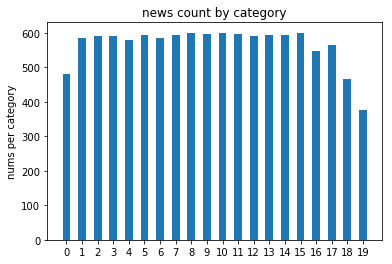

In [8]:
from collections import Counter

def total_news_class(data):
    news_category = dict(Counter(data))
    print(news_category)

    x_val = [val for val in news_category.keys()]
    y_val = [news_category[x] for x in x_val]
    plt.bar(left=x_val,height=y_val,width=0.5)
    plt.xticks(x_val)
    plt.title('news count by category')
    plt.ylabel('nums per category')
    plt.show()
total_news_class(news_train.target)

从图表中可知，20类新闻的数量大部分基本相同，均在550-600左右，仅有三组新闻数量偏少，分别为480，465，377，也属于可以接受的范围；



## 清洗数据 ##
- 去掉所有的单词符号；
- #词干提取，将过去式，进行时态等单词转化为原词根,采用了nltk所附带的snowball模式
- 在几个分类器上对比，发现词干提取并没有什么用，acc-score 反而降低，遂决定不做词干提取；
- 将字母均转化为小写

In [9]:
import re
#import nltk
#import nltk.stem  

def preprocessor(text):
    text = re.sub('[\W]+', ' ', text.lower()) 

    #new_text =[]
    #snowball = nltk.stem.SnowballStemmer('english')  
    #text = [snowball.stem(word) for word in text.split()]
    #text = ' '.join(text)

    return text.strip()
train_data=list(map(preprocessor,news_train.data))
#test_data=list(map(preprocessor,news_test.data))
print(train_data[0])

from lerxst wam umd edu where s my thing subject what car is this nntp posting host rac3 wam umd edu organization university of maryland college park lines 15 i was wondering if anyone out there could enlighten me on this car i saw the other day it was a 2 door sports car looked to be from the late 60s early 70s it was called a bricklin the doors were really small in addition the front bumper was separate from the rest of the body this is all i know if anyone can tellme a model name engine specs years of production where this car is made history or whatever info you have on this funky looking car please e mail thanks il brought to you by your neighborhood lerxst


- 文档探索
    - 探索文档长度
    - 探索所有文档中词频分布

In [10]:
total_word_class = Counter()
d_length = []
def count_doc(text):
    for doc in text:
        d_length.append(len(doc.split()))
        for word in doc.split():
            total_word_class[word] += 1
    return d_length, total_word_class

train_d_length, train_total_word_class = count_doc(train_data)
print(train_total_word_class.most_common(10))
print('The max length of document is {},the min length of document is {}, the median length is {}'\
    .format(np.max(d_length),np.min(d_length), np.median(d_length)))

[('the', 146532), ('to', 75064), ('of', 69034), ('a', 64195), ('ax', 62406), ('and', 57957), ('i', 53036), ('in', 49401), ('is', 43480), ('that', 39264)]
The max length of document is 16197,the min length of document is 18, the median length is 191.0


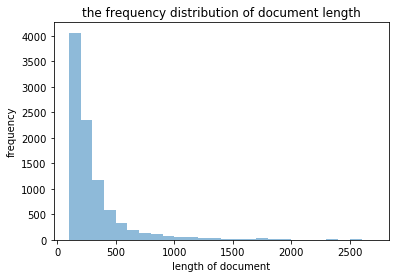

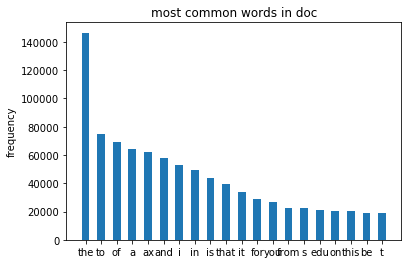

In [11]:
def count_frequency():
    plt.hist(d_length, bins=range(100,2800,100), histtype="stepfilled", alpha=.5)  
    plt.xlabel('length of document')
    plt.ylabel('frequency')
    plt.title('the frequency distribution of document length')
    plt.show()


    x_val = [i[0] for i in train_total_word_class.most_common(20)]
    y_val = [i[1] for i in train_total_word_class.most_common(20)]
    plt.bar(left=range(20),height=y_val,width=0.5)
    plt.xticks(range(20),x_val)
    plt.title('most common words in doc')
    plt.ylabel('frequency')
    plt.show()
    
count_frequency()

- 显然，观察可知，文档长度分布为一拖尾的偏态分布，但是拖尾数据量很少，绝大多数文档长度在0-2000 单词之间，文档最短长度18，最长长度16197，中位数长度191， 文档长度分布可近似看作正态分布，不再进行特征处理；

- 文档中常见词分布：高频词为各类介词（the,of,to, in）及连词和助词（and, is, i, be）等，符合常见高频词分布，最高频词为('the', 146532)，没有异常的高频词，可使用常规停用词；

## 加权词频TF-IDF向量 ##

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

#vectorizer = TfidfVectorizer(preprocessor=preprocessor, stop_words='english', min_df=0.001)
vectorizer = TfidfVectorizer(preprocessor=preprocessor, stop_words='english', min_df=0.002,max_df=0.6,use_idf=True)
X_train = vectorizer.fit_transform(news_train.data)
Y_train = news_train.target
X_test = vectorizer.transform(news_test.data) 
Y_test = news_test.target

In [15]:
print(X_train.shape)

(11314, 7951)


切分数据，划分出10%验证集用于调参

In [16]:
from sklearn import model_selection

x_train, x_val, y_train, y_val = model_selection.train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

In [17]:
#import sklearn.metrics

def evalute_score(model, x, y):
    predicted_y = model.predict(x)
    print(model.__class__.__name__)
    print('--------------------------------------------')
    print(classification_report(y, predicted_y))
    print('--------------------------------------------')
    print(accuracy_score(y, predicted_y))

#### 基准分类器 ####

以决策树为基准分类器，以其在验证集/测试集得分为基准目标

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from xgboost.sklearn import XGBClassifier

tree_model = DecisionTreeClassifier(random_state=10)
tree_model.fit(x_train, y_train)

evalute_score(tree_model, x_val, y_val)

D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


DecisionTreeClassifier
--------------------------------------------
             precision    recall  f1-score   support

          0       0.71      0.72      0.72        47
          1       0.43      0.50      0.46        46
          2       0.60      0.56      0.58        54
          3       0.43      0.50      0.46        62
          4       0.82      0.67      0.74        67
          5       0.59      0.55      0.57        55
          6       0.61      0.70      0.65        60
          7       0.76      0.66      0.71        64
          8       0.80      0.79      0.80        52
          9       0.60      0.80      0.69        55
         10       0.87      0.74      0.80        53
         11       0.80      0.90      0.85        52
         12       0.53      0.51      0.52        65
         13       0.69      0.80      0.74        59
         14       0.71      0.66      0.69        68
         15       0.73      0.73      0.73        52
         16       0.78      0.

In [19]:
nb_model = MultinomialNB()
nb_model.fit(x_train, y_train)

svc_model = LinearSVC(random_state=10)
svc_model.fit(x_train,y_train)

xgb_model = XGBClassifier(seed=10)
xgb_model.fit(x_train,y_train)

models = [nb_model,svc_model,xgb_model]
for model in models:
    evalute_score(model, x_val, y_val)

MultinomialNB
--------------------------------------------
             precision    recall  f1-score   support

          0       0.89      0.87      0.88        47
          1       0.70      0.80      0.75        46
          2       0.85      0.87      0.86        54
          3       0.70      0.77      0.73        62
          4       0.94      0.90      0.92        67
          5       0.79      0.87      0.83        55
          6       0.82      0.85      0.84        60
          7       0.92      0.92      0.92        64
          8       0.96      0.92      0.94        52
          9       0.98      0.98      0.98        55
         10       0.93      0.98      0.95        53
         11       1.00      0.96      0.98        52
         12       0.91      0.80      0.85        65
         13       0.95      0.93      0.94        59
         14       0.95      0.93      0.94        68
         15       0.72      0.96      0.83        52
         16       0.85      0.98      0

In [20]:
print(x_train.shape)
print(y_train.shape)

(10182, 7951)
(10182,)


#### 模型调优 ####

对贝叶斯，主要调节平滑参数alpah；

In [21]:
from sklearn.model_selection import GridSearchCV,KFold

parameters = {'alpha':[round(0.005*i, 3) for i in range(1, 180, 9)]}
kfold= KFold(n_splits=5,random_state=10)

nb_grid_obj = GridSearchCV(nb_model,parameters,cv=kfold)
nb_grid_obj.fit(x_train,y_train)

nb_best_param = nb_grid_obj.best_params_
best_nb = nb_grid_obj.best_estimator_

对LinearSVC， 主要调节C值，tol值，max_iter值：

In [22]:
C = [0.1,0.5,0.9,1.3,1.7]
tol = [1e-3, 1e-2, 0.1]
max_iter = [1e3, 5e3, 1e4]
parameters = {'C': C, 'tol': tol, 'max_iter':max_iter}
kfold= KFold(n_splits=5,random_state=10)

svc_grid_obj = GridSearchCV(svc_model,parameters,cv=kfold)
svc_grid_obj.fit(x_train,y_train)

svc_best_param = svc_grid_obj.best_params_
best_svc = svc_grid_obj.best_estimator_

对Xgb，主要有learning_rate，max_depth，n_estimators，gamma参数进行优化，这里选取了学习率进行优化

In [23]:
from sklearn.model_selection import GridSearchCV,KFold
#n_estimators = [n for n in range(50,211, 40)]
#max_depth = [n for n in range(3,9)]
learning_rate = [0.001, 0.01, 0.1]

parameters = {'learning_rate': learning_rate}
kfold= KFold(n_splits=5,random_state=10)

xgb_grid_obj = GridSearchCV(xgb_model,parameters,cv=kfold)

xgb_grid_obj.fit(x_train,y_train)

xgb_best_param = xgb_grid_obj.best_params_
best_xgb = xgb_grid_obj.best_estimator_

In [26]:
best_models = [best_nb,best_svc, best_xgb]
print('Best param for MultinomialNB model {}:'.format(nb_best_param))
print('Best param for LinearSVC model: {}'.format(svc_best_param) )
print('Best param for Xgboost model:{}'.format(xgb_best_param))

for model in best_models:
    evalute_score(model, x_val, y_val)

Best param for MultinomialNB model {'alpha': 0.05}:
Best param for LinearSVC model: {'max_iter': 1000.0, 'tol': 0.001, 'C': 0.9}
Best param for Xgboost model:{'learning_rate': 0.1}
MultinomialNB
--------------------------------------------
             precision    recall  f1-score   support

          0       0.90      0.94      0.92        47
          1       0.73      0.87      0.79        46
          2       0.84      0.80      0.82        54
          3       0.74      0.79      0.77        62
          4       0.88      0.88      0.88        67
          5       0.81      0.85      0.83        55
          6       0.78      0.90      0.84        60
          7       0.92      0.88      0.90        64
          8       0.90      0.88      0.89        52
          9       0.98      0.96      0.97        55
         10       0.94      0.96      0.95        53
         11       1.00      0.96      0.98        52
         12       0.91      0.80      0.85        65
         13      

- 在测试集上Run：

In [28]:
models_last = [tree_model,best_nb,best_svc, best_xgb]
for model in models_last:
    evalute_score(model, X_test, Y_test)

DecisionTreeClassifier
--------------------------------------------
             precision    recall  f1-score   support

          0       0.44      0.47      0.46       319
          1       0.42      0.43      0.43       389
          2       0.55      0.58      0.57       394
          3       0.41      0.46      0.44       392
          4       0.59      0.58      0.59       385
          5       0.51      0.48      0.50       395
          6       0.66      0.72      0.69       390
          7       0.56      0.60      0.57       396
          8       0.77      0.76      0.76       398
          9       0.55      0.57      0.56       397
         10       0.73      0.71      0.72       399
         11       0.77      0.71      0.74       396
         12       0.38      0.36      0.37       393
         13       0.52      0.48      0.50       396
         14       0.67      0.63      0.65       394
         15       0.68      0.73      0.70       398
         16       0.52      0.


#### Ensemble Classifier ####

将朴素贝叶斯，决策树，XGBoost 这三个在上文表现稍弱的分类器组合起来，组合成集合分类器，进行分类预测；

In [34]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

ensemble_model = VotingClassifier(estimators=[('tree', tree_model), ('NB', best_nb), ('xgb',best_xgb)], voting='soft', weights=[1, 1, 1])

for model, name in zip([tree_model,best_nb, best_xgb,ensemble_model], ['Decision Tree', 'Naive Bayes', 'XGBBoosting','Ensemble']):
    scores = cross_val_score(model, x_train, y_train, cv=5,scoring='accuracy')
    print("Accuracy: {:.2f} (+/- {:.2f}) [{}]" .format(scores.mean(), scores.std(), name))

Accuracy: 0.64 (+/- 0.01) [Decision Tree]
Accuracy: 0.88 (+/- 0.00) [Naive Bayes]
Accuracy: 0.80 (+/- 0.01) [XGBBoosting]
Accuracy: 0.86 (+/- 0.01) [Ensemble]


In [36]:
ensemble_model.fit(x_train,y_train)
evalute_score(ensemble_model, X_test, Y_test)

VotingClassifier
--------------------------------------------
             precision    recall  f1-score   support

          0       0.72      0.71      0.71       319
          1       0.65      0.69      0.67       389
          2       0.72      0.72      0.72       394
          3       0.65      0.70      0.67       392
          4       0.78      0.77      0.78       385
          5       0.77      0.73      0.75       395
          6       0.82      0.87      0.84       390
          7       0.83      0.84      0.83       396
          8       0.91      0.93      0.92       398
          9       0.87      0.89      0.88       397
         10       0.91      0.96      0.94       399
         11       0.91      0.90      0.91       396
         12       0.69      0.61      0.64       393
         13       0.80      0.72      0.76       396
         14       0.86      0.87      0.87       394
         15       0.84      0.92      0.88       398
         16       0.68      0.88    

构造的柔性集合分类器在测试集上得分为79.05%，不如单独的朴素贝叶斯分类器，可能还需要更多的改进；

最终，经过比较，LinearSVC 在20news 测试集上表现最好，准确率为81.25%，通过热力图，展现LinearSVC在20类新闻中分别的预测情况

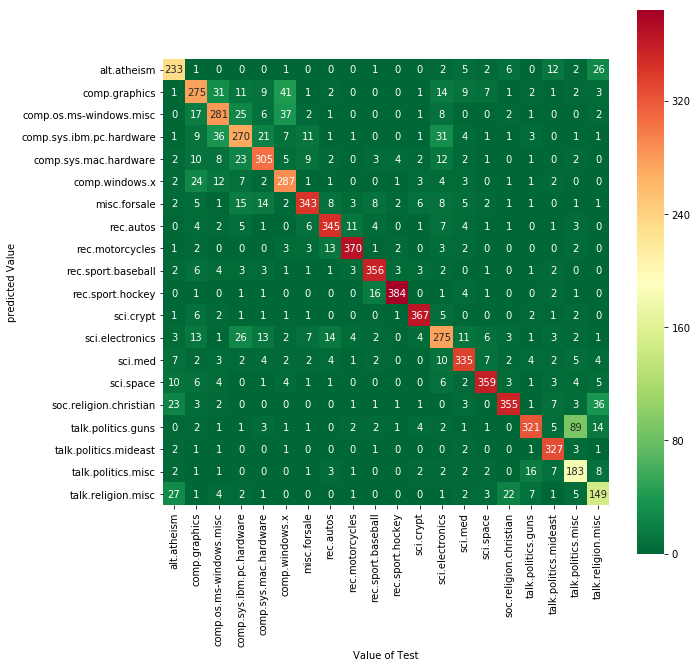

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(10,10))
Y_pred = best_svc.predict(X_test)
martix = confusion_matrix(Y_test, Y_pred)

sns.heatmap(martix.T, square=True, annot=True, fmt='d',cmap='RdYlGn_r',
            xticklabels = news_test.target_names, yticklabels = news_test.target_names)
plt.xlabel('Value of Test')
plt.ylabel('predicted Value')